In [71]:
## libreria y archivo a trabajar
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.stats import poisson
import seaborn as sns
from scipy import stats


merge = pd.read_excel("../DatosProcesados/Merge_BrasilWalmart.xlsx")

merge.info()        # tipos de dato y nulos
merge.shape         # filas y columnas
merge.head(3)       # primeras filas
merge.columns       # nombres de columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101624 entries, 0 to 101623
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       101624 non-null  datetime64[ns]
 1   customer_state                 101624 non-null  object        
 2   payment_value                  101624 non-null  float64       
 3   freight_value                  101624 non-null  float64       
 4   payment_type                   101624 non-null  object        
 5   payment_installments           101624 non-null  int64         
 6   price                          101624 non-null  float64       
 7   product_category               101624 non-null  object        
 8   order_approved_at              101624 non-null  datetime64[ns]
 9   order_delivered_carrier_date   101624 non-null  datetime64[ns]
 10  order_delivered_customer_date  101624 non-null  datetime64[ns]
 11  

Index(['order_purchase_timestamp', 'customer_state', 'payment_value',
       'freight_value', 'payment_type', 'payment_installments', 'price',
       'product_category', 'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'UF', 'HDI 2017', 'HDI Education 2017',
       'HDI Wealth 2017', 'HDI Health 2017', 'Population',
       'Demographic Density', 'GDP', 'GDP rate', 'Poverty', 'Region',
       'Latitude', 'Longitude'],
      dtype='object')

In [72]:
## voy a hacer tres cluster segun sus idh considerando cada variable como vector 


#  Agrupo segun el estado
cols_hdi = ["HDI Wealth 2017", "HDI Education 2017", "HDI Health 2017"]
idh_estado = merge.groupby("customer_state")[cols_hdi].mean().reset_index()

#  utilizamos scaler 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(idh_estado[cols_hdi])

inertias, sils, Ks = [], [], range(2, 7)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

print("Inercia por k:", dict(zip(Ks, inertias)))
print("Silhouette por k:", dict(zip(Ks, [round(s, 3) for s in sils])))



Inercia por k: {2: 30.975946618010337, 3: 23.83685425276877, 4: 17.03014404849031, 5: 12.011868673428854, 6: 10.057220151376187}
Silhouette por k: {2: 0.497, 3: 0.35, 4: 0.32, 5: 0.364, 6: 0.308}



 Top 10 productos por cluster:

 Cluster BAJO:
    cluster_idh      product_category  valor_total  cantidad  ticket_promedio
26        bajo                  home    286674.03      1494       191.883554
25        bajo         health_beauty    172738.44       885       195.184678
21        bajo           electronics    157971.53       878       179.922016
24        bajo                 gifts    112936.06       455       248.211121
19        bajo  computer accessories     99920.52       476       209.917059
27        bajo                others     97030.89       493       196.817221
30        bajo         sport leisure     89007.48       490       181.647918
31        bajo                  toys     79823.20       427       186.939578
17        bajo            automotive     72781.86       306       237.849216
22        bajo               fashion     32896.49       262       125.559122

 Cluster MEDIO:
    cluster_idh      product_category  valor_total  cantidad  ticket_promedio
42       

<Figure size 800x600 with 0 Axes>

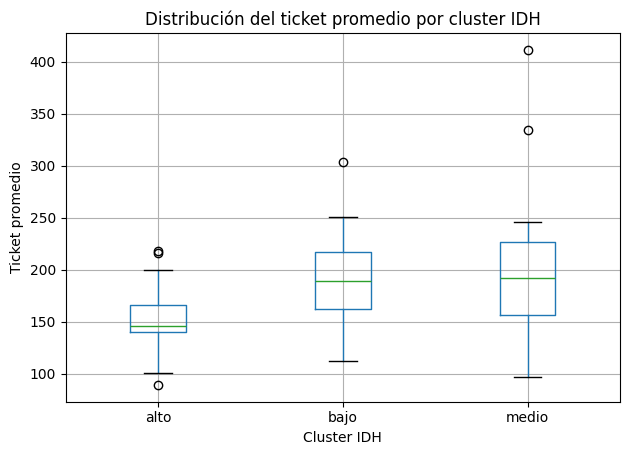


Ticket promedio general por cluster:
  cluster_idh  ticket_promedio_cluster
0        alto               151.976605
1        bajo               190.060829
2       medio               202.412486


In [79]:
## las mejoras segun inercias se da en k=3 y k=4
## segun silohuette - k=2 es la que mejor se ajusta pero tendria solo categorias baja y alta
        #           - k=3 y k=4 son aceptables y mejor para estudiar 

# clustering con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
idh_estado["cluster_idh_raw"] = kmeans.fit_predict(X_scaled)

# ordenamos por idh y renombramos bajo/medio/alto
order = idh_estado.groupby("cluster_idh_raw")["HDI Wealth 2017"].mean().sort_values().index.tolist()
rename_map = {order[0]: "bajo", order[1]: "medio", order[2]: "alto"}
idh_estado["cluster_idh"] = idh_estado["cluster_idh_raw"].map(rename_map)
idh_estado.drop(columns=["cluster_idh_raw"], inplace=True)

# Anexamos a la tabla principal
merge = merge.merge(idh_estado[["customer_state", "cluster_idh"]], on="customer_state", how="left")


# Analisis de productos por cluster 


productos_cluster = (
    merge.groupby(["cluster_idh", "product_category"], dropna=False)
    .agg(
        valor_total=("payment_value", "sum"),
        cantidad=("product_category", "size")
    )
    .reset_index()
)
productos_cluster["ticket_promedio"] = productos_cluster["valor_total"] / productos_cluster["cantidad"]

#  Top 10 productos por cluster 

print("\n Top 10 productos por cluster:")
for c in ["bajo", "medio", "alto"]:
    top = (
        productos_cluster[productos_cluster["cluster_idh"] == c]
        .sort_values("valor_total", ascending=False)
        .head(10)
    )
    print(f"\n Cluster {c.upper()}:\n", top)

#  Outliers ticket promedio por cluster 
outliers_clusters = [] 
for c in ["bajo", "medio", "alto"]:
    df_c = productos_cluster[productos_cluster["cluster_idh"] == c].copy()
    
    Q1 = df_c["ticket_promedio"].quantile(0.25)
    Q3 = df_c["ticket_promedio"].quantile(0.75)
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    
    df_out = df_c[(df_c["ticket_promedio"] < low_lim) | (df_c["ticket_promedio"] > up_lim)].copy()
    df_out["lim_inf"] = low_lim
    df_out["lim_sup"] = up_lim
    df_out["cluster"] = c
    
    outliers_clusters.append(df_out)

outliers_clusters = pd.concat(outliers_clusters, ignore_index=True)


# Boxplot 
plt.figure(figsize=(8,6))
productos_cluster.boxplot(column="ticket_promedio", by="cluster_idh")
plt.title("Distribución del ticket promedio por cluster IDH")
plt.suptitle("")
plt.ylabel("Ticket promedio")
plt.xlabel("Cluster IDH")
plt.tight_layout()
plt.show()

# Ticket promedio general por cluster 
ticket_cluster = (
    productos_cluster.groupby("cluster_idh")["ticket_promedio"]
    .mean()
    .reset_index()
    .rename(columns={"ticket_promedio": "ticket_promedio_cluster"})
)

print("\nTicket promedio general por cluster:")
print(ticket_cluster)


 Ticket promedio general por cluster de Pobreza:
  cluster_poverty  ticket_promedio_cluster
0            alto               191.815586
1            bajo               152.137504
2           medio               203.676582


<Figure size 800x600 with 0 Axes>

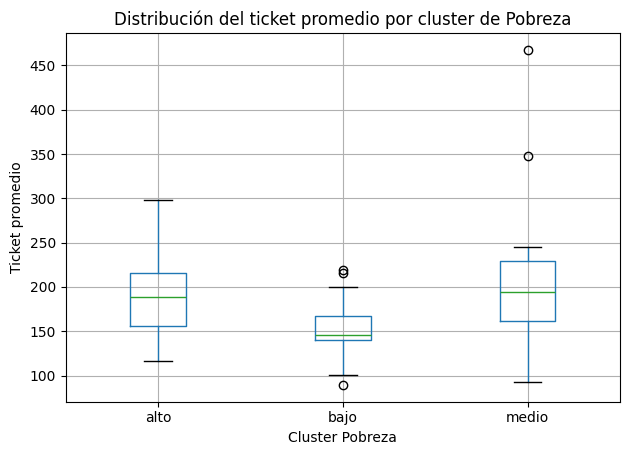


 Top 10 productos por cluster de Pobreza:

 Cluster POBREZA BAJO:
    cluster_poverty      product_category  valor_total  cantidad  \
26            bajo                  home   4112171.91     28400   
25            bajo         health_beauty   1566171.17     10594   
21            bajo           electronics   1228117.32      8535   
24            bajo                 gifts   1078851.81      4936   
27            bajo                others   1032119.90      6075   
30            bajo         sport leisure   1006280.40      7043   
19            bajo  computer accessories    954480.36      6131   
31            bajo                  toys    921289.40      6225   
17            bajo            automotive    579876.62      3499   
22            bajo               fashion    373577.39      3233   

    ticket_promedio  
26       144.794786  
25       147.835678  
21       143.891895  
24       218.568033  
27       169.896280  
30       142.876672  
19       155.681024  
31       147.99829

In [80]:
## REPITO SEGUN POBREZA

# Agrupo pobreza por estado 
poverty_estado = merge.groupby("customer_state")["Poverty"].mean().reset_index()

# Escalo y clusterizo con K=3
X_pov = scaler.fit_transform(poverty_estado[["Poverty"]])

kmeans_pov = KMeans(n_clusters=3, random_state=42, n_init=50)
poverty_estado["cluster_poverty_raw"] = kmeans_pov.fit_predict(X_pov)

# Ordeno por pobreza y renombro a bajo/medio/alto
order_pov = poverty_estado.groupby("cluster_poverty_raw")["Poverty"].mean().sort_values().index.tolist()
rename_map_pov = {order_pov[0]: "bajo", order_pov[1]: "medio", order_pov[2]: "alto"}
poverty_estado["cluster_poverty"] = poverty_estado["cluster_poverty_raw"].map(rename_map_pov)
poverty_estado.drop(columns=["cluster_poverty_raw"], inplace=True)

# Agrego a tabla principal 
merge = merge.drop(columns=["cluster_poverty"], errors="ignore")
merge = merge.merge(poverty_estado[["customer_state", "cluster_poverty"]], on="customer_state", how="left")

# Analisis de productos por cluster de Pobreza 
productos_pov = (
    merge.groupby(["cluster_poverty", "product_category"], dropna=False)
    .agg(
        valor_total=("payment_value", "sum"),
        cantidad=("product_category", "size")
    )
    .reset_index()
)
productos_pov["ticket_promedio"] = productos_pov["valor_total"] / productos_pov["cantidad"]

# Ticket promedio general por cluster de Pobreza 
ticket_pov = (
    productos_pov.groupby("cluster_poverty")["ticket_promedio"]
    .mean()
    .reset_index()
    .rename(columns={"ticket_promedio": "ticket_promedio_cluster"})
)

print("\n Ticket promedio general por cluster de Pobreza:")
print(ticket_pov)

# Boxplot 

plt.figure(figsize=(8,6))
productos_pov.boxplot(column="ticket_promedio", by="cluster_poverty")
plt.title("Distribución del ticket promedio por cluster de Pobreza")
plt.suptitle("")
plt.ylabel("Ticket promedio")
plt.xlabel("Cluster Pobreza")
plt.tight_layout()
plt.show()

# Top 10 productos por cluster de Pobreza 
print("\n Top 10 productos por cluster de Pobreza:")
for c in ["bajo", "medio", "alto"]:
    top = (
        productos_pov[productos_pov["cluster_poverty"] == c]
        .sort_values("valor_total", ascending=False)
        .head(10)
    )
    print(f"\n Cluster POBREZA {c.upper()}:\n", top)

 Outliers detectados : 6 de 48 (12.5%)

 Top 10 productos por cluster (SIN outliers):

🟦 Cluster BAJO:
 cluster_idh     product_category  valor_total  cantidad  ticket_promedio
       bajo                 home    286674.03      1494       191.883554
       bajo        health_beauty    172738.44       885       195.184678
       bajo          electronics    157971.53       878       179.922016
       bajo                gifts    112936.06       455       248.211121
       bajo computer accessories     99920.52       476       209.917059
       bajo               others     97030.89       493       196.817221
       bajo        sport leisure     89007.48       490       181.647918
       bajo                 toys     79823.20       427       186.939578
       bajo           automotive     72781.86       306       237.849216
       bajo              fashion     32896.49       262       125.559122

🟦 Cluster MEDIO:
 cluster_idh     product_category  valor_total  cantidad  ticket_promedio
 

<Figure size 800x600 with 0 Axes>

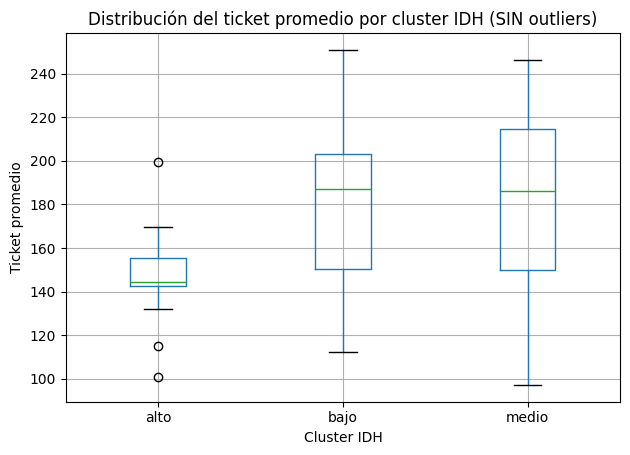


 Ticket promedio por cluster (CON vs SIN outliers):
cluster_idh  ticket_promedio_cluster_CON  ticket_promedio_cluster_SIN      delta
       alto                   151.976605                   146.790570  -5.186035
       bajo                   190.060829                   182.501936  -7.558893
      medio                   202.412486                   178.036994 -24.375492


In [81]:

# voy a eliminar los outlier SEGUN IDH

# Limites IQR por cluster sobre ticket_promedio
q = productos_cluster.groupby("cluster_idh")["ticket_promedio"].agg(
    q1=lambda s: s.quantile(0.25),
    q3=lambda s: s.quantile(0.75)
).reset_index()
q["iqr"] = q["q3"] - q["q1"]
q["low"] = q["q1"] - 1.5 * q["iqr"]
q["up"]  = q["q3"] + 1.5 * q["iqr"]

# Uno los limites y marco outliers
pc = productos_cluster.merge(q[["cluster_idh","low","up"]], on="cluster_idh", how="left")
pc["is_outlier"] = (pc["ticket_promedio"] < pc["low"]) | (pc["ticket_promedio"] > pc["up"])


n_out = pc["is_outlier"].sum()
n_tot = len(pc)
print(f" Outliers detectados : {n_out} de {n_tot} ({n_out/n_tot:.1%})")

# Data sin outliers
productos_cluster_sin = pc.loc[~pc["is_outlier"], ["cluster_idh","product_category","valor_total","cantidad","ticket_promedio"]].copy()


#  Top 10 productos por cluster (SIN outliers) 
print("\n Top 10 productos por cluster (SIN outliers):")
for c in ["bajo", "medio", "alto"]:
    top = (
        productos_cluster_sin[productos_cluster_sin["cluster_idh"] == c]
        .sort_values("valor_total", ascending=False)
        .head(10)
    )
    print(f"\n🟦 Cluster {c.upper()}:\n", top.to_string(index=False))

#  Boxplot del ticket promedio por cluster (SIN outliers) 

plt.figure(figsize=(8,6))
productos_cluster_sin.boxplot(column="ticket_promedio", by="cluster_idh")
plt.title("Distribución del ticket promedio por cluster IDH (SIN outliers)")
plt.suptitle("")
plt.ylabel("Ticket promedio")
plt.xlabel("Cluster IDH")
plt.tight_layout()
plt.show()

#  Ticket promedio general por cluster (CON vs SIN outliers) 
ticket_con = (
    productos_cluster.groupby("cluster_idh")["ticket_promedio"]
    .mean()
    .reset_index()
    .rename(columns={"ticket_promedio": "ticket_promedio_cluster_CON"})
)
ticket_sin = (
    productos_cluster_sin.groupby("cluster_idh")["ticket_promedio"]
    .mean()
    .reset_index()
    .rename(columns={"ticket_promedio": "ticket_promedio_cluster_SIN"})
)

ticket_comp = ticket_con.merge(ticket_sin, on="cluster_idh", how="outer")
ticket_comp["delta"] = ticket_comp["ticket_promedio_cluster_SIN"] - ticket_comp["ticket_promedio_cluster_CON"]

print("\n Ticket promedio por cluster (CON vs SIN outliers):")
print(ticket_comp.to_string(index=False))



 Outliers detectados : 5 de 48 (10.4%)

 Top 10 productos por cluster de Pobreza (SIN outliers):

 Cluster POBREZA BAJO:
 cluster_poverty     product_category  valor_total  cantidad  ticket_promedio
           bajo                 home   4112171.91     28400       144.794786
           bajo        health_beauty   1566171.17     10594       147.835678
           bajo          electronics   1228117.32      8535       143.891895
           bajo               others   1032119.90      6075       169.896280
           bajo        sport leisure   1006280.40      7043       142.876672
           bajo computer accessories    954480.36      6131       155.681024
           bajo                 toys    921289.40      6225       147.998297
           bajo           automotive    579876.62      3499       165.726385
           bajo              fashion    373577.39      3233       115.551311
           bajo                 pets    236556.32      1645       143.803234

 Cluster POBREZA MEDIO:
 clust

<Figure size 800x600 with 0 Axes>

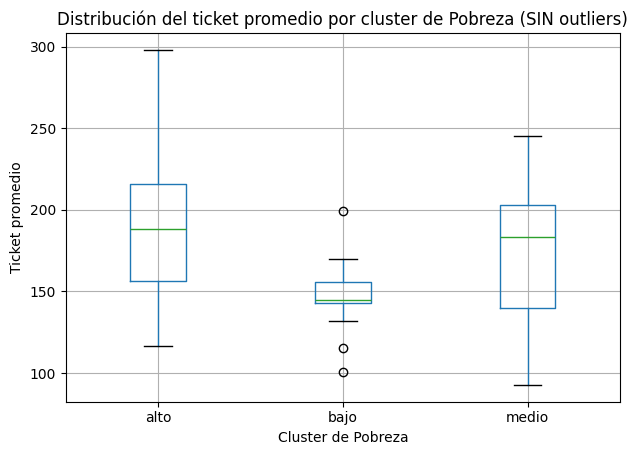


 Ticket promedio por cluster de Pobreza (comparación CON vs SIN outliers):
cluster_poverty  ticket_promedio_cluster_CON  ticket_promedio_cluster_SIN      delta
           alto                   191.815586                   191.815586   0.000000
           bajo                   152.137504                   146.920990  -5.216515
          medio                   203.676582                   174.546873 -29.129709


In [82]:
## ELIMINO SEGUN POBREZA

# Limites IQR por cluster_poverty sobre ticket_promedio
q_pov = productos_pov.groupby("cluster_poverty")["ticket_promedio"].agg(
    q1=lambda s: s.quantile(0.25),
    q3=lambda s: s.quantile(0.75)
).reset_index()
q_pov["iqr"] = q_pov["q3"] - q_pov["q1"]
q_pov["low"] = q_pov["q1"] - 1.5 * q_pov["iqr"]
q_pov["up"]  = q_pov["q3"] + 1.5 * q_pov["iqr"]

# Uno los limites y marco outliers
pc_pov = productos_pov.merge(q_pov[["cluster_poverty","low","up"]], on="cluster_poverty", how="left")
pc_pov["is_outlier"] = (pc_pov["ticket_promedio"] < pc_pov["low"]) | (pc_pov["ticket_promedio"] > pc_pov["up"])

# Reporte de outliers
n_out_pov = pc_pov["is_outlier"].sum()
n_tot_pov = len(pc_pov)
print(f" Outliers detectados : {n_out_pov} de {n_tot_pov} ({n_out_pov/n_tot_pov:.1%})")

# Data sin outliers
productos_pov_sin = pc_pov.loc[
    ~pc_pov["is_outlier"],
    ["cluster_poverty","product_category","valor_total","cantidad","ticket_promedio"]
].copy()


# Top 10 productos por pobreza (SIN outliers) 
print("\n Top 10 productos por cluster de Pobreza (SIN outliers):")
for c in ["bajo", "medio", "alto"]:
    top = (
        productos_pov_sin[productos_pov_sin["cluster_poverty"] == c]
        .sort_values("valor_total", ascending=False)
        .head(10)
    )
    print(f"\n Cluster POBREZA {c.upper()}:\n", top.to_string(index=False))

# Boxplot del ticket promedio por pobreza (SIN outliers) 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
productos_pov_sin.boxplot(column="ticket_promedio", by="cluster_poverty")
plt.title("Distribución del ticket promedio por cluster de Pobreza (SIN outliers)")
plt.suptitle("")
plt.ylabel("Ticket promedio")
plt.xlabel("Cluster de Pobreza")
plt.tight_layout()
plt.show()

#  Ticket promedio general por pobreza (CON vs SIN outliers) ---
ticket_con_pov = (
    productos_pov.groupby("cluster_poverty")["ticket_promedio"]
    .mean()
    .reset_index()
    .rename(columns={"ticket_promedio": "ticket_promedio_cluster_CON"})
)
ticket_sin_pov = (
    productos_pov_sin.groupby("cluster_poverty")["ticket_promedio"]
    .mean()
    .reset_index()
    .rename(columns={"ticket_promedio": "ticket_promedio_cluster_SIN"})
)

ticket_comp_pov = ticket_con_pov.merge(ticket_sin_pov, on="cluster_poverty", how="outer")
ticket_comp_pov["delta"] = ticket_comp_pov["ticket_promedio_cluster_SIN"] - ticket_comp_pov["ticket_promedio_cluster_CON"]

print("\n Ticket promedio por cluster de Pobreza (comparación CON vs SIN outliers):")
print(ticket_comp_pov.to_string(index=False))

In [83]:
## correlacion  # Matriz cruzada: IDH lusters vs Pobreza
cross = pd.crosstab(merge["cluster_idh"], merge["cluster_poverty"], normalize="index") * 100
print("\n Distribucion porcentual de clusters IDH vs Pobreza:")
print(cross.round(1))

# Correlacion entre IDH y Pobreza 
idh_poverty_corr = (
    merge.groupby("customer_state")[["HDI 2017", "Poverty"]]
    .mean()
    .corr()
)

print("\n Correlacion entre IDH y Pobreza :")
print(idh_poverty_corr)




 Distribucion porcentual de clusters IDH vs Pobreza:
cluster_poverty  alto   bajo  medio
cluster_idh                        
alto              0.0  100.0    0.0
bajo             94.6    0.0    5.4
medio            32.6    5.1   62.2

 Correlacion entre IDH y Pobreza :
          HDI 2017   Poverty
HDI 2017  1.000000 -0.885754
Poverty  -0.885754  1.000000


In [38]:
## en que categorias suceden los outliers por cluster
outliers_categorias = (
    pc[pc["is_outlier"]]
    .groupby(["cluster_idh","product_category"])
    .agg(
        num_outliers=("is_outlier","size"),
        valor_total=("valor_total","sum"),
            )
    .reset_index()
    .sort_values(["cluster_idh","num_outliers"], ascending=[True,False])
)

print("Categorias con outliers por cluster:\n")
print(outliers_categorias.to_string(index=False))



# Outliers por categorías según Pobreza

outliers_categorias_pov = (
    pc_pov[pc_pov["is_outlier"]]
    .groupby(["cluster_poverty","product_category"])
    .agg(
        num_outliers=("is_outlier","size"),
        valor_total=("valor_total","sum"),
    )
    .reset_index()
    .sort_values(["cluster_poverty","num_outliers"], ascending=[True,False])
)

print(" Categorías con outliers por cluster de Pobreza:\n")
print(outliers_categorias_pov.to_string(index=False))





Categorias con outliers por cluster:

cluster_idh product_category  num_outliers  valor_total
       alto     construction             1    320058.06
       alto             food             1     82924.68
       alto            gifts             1   1073841.63
       bajo         services             1     13654.99
      medio     construction             1     25737.61
      medio         services             1     16061.26
 Categorías con outliers por cluster de Pobreza:

cluster_poverty product_category  num_outliers  valor_total
           bajo     construction             1    322228.52
           bajo             food             1     83051.13
           bajo            gifts             1   1078851.81
          medio     construction             1     16671.70
          medio         services             1     14035.26


In [90]:
# Distribucion metodos de pago por cluster
pagos_cluster = (
    merge.groupby(["cluster_idh","payment_type"])
    .agg(
        total_valor=("payment_value","sum"),
        num_pagos=("payment_type","count")
    )
    .reset_index()
)

# % participacion dentro de cada cluster (por cantidad de pagos)
pagos_cluster["pct_num_pagos"] = pagos_cluster.groupby("cluster_idh")["num_pagos"].transform(lambda x: x / x.sum() * 100)

# % participacion dentro de cada cluster (por valor pagado) 
pagos_cluster["pct_valor"] = pagos_cluster.groupby("cluster_idh")["total_valor"].transform(lambda x: x / x.sum() * 100)

# ordeno por el % de número de pagos
pagos_cluster = pagos_cluster.sort_values(["cluster_idh","pct_num_pagos"], ascending=[True, False])

print(" % de número de pagos por metodo y cluster:")
print(pagos_cluster[["cluster_idh","payment_type","pct_num_pagos"]].to_string(index=False))

print(" % de valor pagado por metodo y cluster:")
print(pagos_cluster[["cluster_idh","payment_type","pct_valor"]].to_string(index=False))


# Distribucion de metodos de pago por cluster de Pobreza

pagos_poverty = (
    merge.groupby(["cluster_poverty","payment_type"])
    .agg(
        total_valor=("payment_value","sum"),
        num_pagos=("payment_type","count")
    )
    .reset_index()
)

# % participacion dentro de cada cluster (por cantidad de pagos)
pagos_poverty["pct_num_pagos"] = pagos_poverty.groupby("cluster_poverty")["num_pagos"].transform(lambda x: x / x.sum() * 100)

# % participacion dentro de cada cluster (por valor pagado)
pagos_poverty["pct_valor"] = pagos_poverty.groupby("cluster_poverty")["total_valor"].transform(lambda x: x / x.sum() * 100)

# Ordeno por cluster y % de número de pagos
pagos_poverty = pagos_poverty.sort_values(["cluster_poverty","pct_num_pagos"], ascending=[True, False])

# Resultados
print(" % de número de pagos por metodo y cluster de Pobreza:")
print(pagos_poverty[["cluster_poverty","payment_type","pct_num_pagos"]].to_string(index=False))

print("% de valor pagado por metodo y cluster de Pobreza:")
print(pagos_poverty[["cluster_poverty","payment_type","pct_valor"]].to_string(index=False))



 % de número de pagos por metodo y cluster:
cluster_idh payment_type  pct_num_pagos
       alto  credit_card      74.406485
       alto          UPI      19.216482
       alto      voucher       4.895601
       alto   debit_card       1.481432
       bajo  credit_card      74.197531
       bajo          UPI      19.058642
       bajo      voucher       5.308642
       bajo   debit_card       1.435185
      medio  credit_card      76.738561
      medio          UPI      16.891756
      medio      voucher       4.938520
      medio   debit_card       1.431163
 % de valor pagado por metodo y cluster:
cluster_idh payment_type  pct_valor
       alto  credit_card  78.487243
       alto          UPI  18.041820
       alto      voucher   2.122636
       alto   debit_card   1.348300
       bajo  credit_card  78.032804
       bajo          UPI  18.704093
       bajo      voucher   2.066010
       bajo   debit_card   1.197093
      medio  credit_card  80.411755
      medio          UPI  16.241636

In [40]:
# Distribucion de cuotas por cluster
cuotas_cluster = (
    merge.groupby(["cluster_idh","payment_installments"])
    .agg(
        num_pagos=("payment_installments","count"),
        valor_total=("payment_value","sum")
    )
    .reset_index()
)

# % de transacciones dentro de cada cluster
cuotas_cluster["pct_num_pagos"] = cuotas_cluster.groupby("cluster_idh")["num_pagos"].transform(
    lambda x: x / x.sum() * 100
)

# Ticket promedio por numero de cuotas
cuotas_cluster["ticket_promedio"] = cuotas_cluster["valor_total"] / cuotas_cluster["num_pagos"]


# Clasificacion de cuotas en rangos 
def clasificar_cuotas(x):
    if x == 1:
        return "1 cuota"
    elif x <= 3:
        return "2-3 cuotas"
    elif x <= 6:
        return "4-6 cuotas"
    else:
        return "7+ cuotas"

merge["cuotas_rango"] = merge["payment_installments"].apply(clasificar_cuotas)

#  Distribucion por cluster y rango de cuotas 
cuotas_rango = (
    merge.groupby(["cluster_idh","cuotas_rango"])
    .agg(num_pagos=("cuotas_rango","count"))
    .reset_index()
)

# Columna de porcentaje dentro de cada cluster 
cuotas_rango["pct_num_pagos"] = cuotas_rango.groupby("cluster_idh")["num_pagos"].transform(
    lambda x: (x / x.sum()) * 100
)

# Ordeno por cluster y cuota
cuotas_rango = cuotas_rango.sort_values(["cluster_idh","cuotas_rango"])

print(" Distribución de cuotas por cluster (con porcentajes):\n")
print(cuotas_rango.to_string(index=False))

#  Distribucion de cuotas por cluster de Pobreza 
cuotas_poverty = (
    merge.groupby(["cluster_poverty","payment_installments"])
    .agg(
        num_pagos=("payment_installments","count"),
        valor_total=("payment_value","sum")
    )
    .reset_index()
)

# % de transacciones dentro de cada cluster
cuotas_poverty["pct_num_pagos"] = cuotas_poverty.groupby("cluster_poverty")["num_pagos"].transform(
    lambda x: x / x.sum() * 100
)

# Ticket promedio por numero de cuotas
cuotas_poverty["ticket_promedio"] = cuotas_poverty["valor_total"] / cuotas_poverty["num_pagos"]

# Clasificación de cuotas en rangos 
def clasificar_cuotas(x):
    if x == 1:
        return "1 cuota"
    elif x <= 3:
        return "2-3 cuotas"
    elif x <= 6:
        return "4-6 cuotas"
    else:
        return "7+ cuotas"

merge["cuotas_rango_pov"] = merge["payment_installments"].apply(clasificar_cuotas)

# Distribucion por cluster de Pobreza y rango de cuotas 
cuotas_rango_pov = (
    merge.groupby(["cluster_poverty","cuotas_rango_pov"])
    .agg(num_pagos=("cuotas_rango_pov","count"))
    .reset_index()
)

#  Columna de porcentaje dentro de cada cluster 
cuotas_rango_pov["pct_num_pagos"] = cuotas_rango_pov.groupby("cluster_poverty")["num_pagos"].transform(
    lambda x: (x / x.sum()) * 100
)

# Ordeno por cluster y cuota
cuotas_rango_pov = cuotas_rango_pov.sort_values(["cluster_poverty","cuotas_rango_pov"])

print(" Distribución de cuotas por cluster de Pobreza (con porcentajes):\n")
print(cuotas_rango_pov.to_string(index=False))



 Distribución de cuotas por cluster (con porcentajes):

cluster_idh cuotas_rango  num_pagos  pct_num_pagos
       alto      1 cuota      45912      50.909817
       alto   2-3 cuotas      19893      22.058481
       alto   4-6 cuotas      13832      15.337702
       alto    7+ cuotas      10546      11.694000
       bajo      1 cuota       2790      43.055556
       bajo   2-3 cuotas       1442      22.253086
       bajo   4-6 cuotas       1270      19.598765
       bajo    7+ cuotas        978      15.092593
      medio      1 cuota       1987      40.052409
      medio   2-3 cuotas       1067      21.507761
      medio   4-6 cuotas       1041      20.983673
      medio    7+ cuotas        866      17.456158
 Distribución de cuotas por cluster de Pobreza (con porcentajes):

cluster_poverty cuotas_rango_pov  num_pagos  pct_num_pagos
           alto          1 cuota       3297      42.536447
           alto       2-3 cuotas       1737      22.410012
           alto       4-6 cuotas     

In [ ]:
#  Agrupo por cluster + producto + rango de cuotas 
productos_cuotas_cluster = (
    merge.groupby(["cluster_idh","product_category","cuotas_rango"])
    .agg(
        num_pagos=("cuotas_rango","count"),
        valor_total=("payment_value","sum")
    )
    .reset_index()
)
productos_cuotas_cluster["ticket_promedio"] = (
    productos_cuotas_cluster["valor_total"] / productos_cuotas_cluster["num_pagos"]
)

def imprimir_top_por_rango(rango, titulo):
    print(f"\nTop 3 productos en {titulo} por cluster:\n")
    for c in ["bajo","medio","alto"]:
        df = (
            productos_cuotas_cluster[
                (productos_cuotas_cluster["cluster_idh"]==c) &
                (productos_cuotas_cluster["cuotas_rango"]==rango)
            ]
            .sort_values("num_pagos", ascending=False)
            .head(3)
            [["product_category","num_pagos","valor_total","ticket_promedio"]]
        )
        if df.empty:
            print(f"— Cluster {c.upper()}: (sin datos)\n")
        else:
            print(f"— Cluster {c.upper()}:\n{df.to_string(index=False)}\n")

# Top 3 con mas cuotas (7+)
imprimir_top_por_rango("7+ cuotas", "7+ cuotas")

# Top 3 con 1 sola cuota
imprimir_top_por_rango("1 cuota", "1 cuota")

# Asegurar el rango de cuotas para Pobreza
def clasificar_cuotas(x):
    if x == 1:
        return "1 cuota"
    elif x <= 3:
        return "2-3 cuotas"
    elif x <= 6:
        return "4-6 cuotas"
    else:
        return "7+ cuotas"

if "cuotas_rango_pov" not in merge.columns:
    merge["cuotas_rango_pov"] = merge["payment_installments"].apply(clasificar_cuotas)

# Agrupo por cluster Pobreza + producto + rango de cuotas 
productos_cuotas_poverty = (
    merge.groupby(["cluster_poverty","product_category","cuotas_rango_pov"])
    .agg(
        num_pagos=("cuotas_rango_pov","count"),
        valor_total=("payment_value","sum")
    )
    .reset_index()
)
productos_cuotas_poverty["ticket_promedio"] = (
    productos_cuotas_poverty["valor_total"] / productos_cuotas_poverty["num_pagos"]
)

def imprimir_top_por_rango_pov(rango, titulo):
    print(f"\n Top 3 productos en {titulo} por cluster de Pobreza:\n")
    for c in ["bajo","medio","alto"]:
        df = (
            productos_cuotas_poverty[
                (productos_cuotas_poverty["cluster_poverty"]==c) &
                (productos_cuotas_poverty["cuotas_rango_pov"]==rango)
            ]
            .sort_values("num_pagos", ascending=False)
            .head(3)
            [["product_category","num_pagos","valor_total","ticket_promedio"]]
        )
        if df.empty:
            print(f"— Cluster {c.upper()}: (sin datos)\n")
        else:
            print(f"— Cluster {c.upper()}:\n{df.to_string(index=False)}\n")

# Top 3 con más cuotas (7+)
imprimir_top_por_rango_pov("7+ cuotas", "7+ cuotas")

# Top 3 con 1 sola cuota
imprimir_top_por_rango_pov("1 cuota", "1 cuota")



Top 3 productos en 7+ cuotas por cluster:

— Cluster BAJO:
product_category  num_pagos  valor_total  ticket_promedio
            home        275     88802.30       322.917455
   health_beauty        143     51586.08       360.741818
           gifts        109     46240.70       424.226606

— Cluster MEDIO:
product_category  num_pagos  valor_total  ticket_promedio
            home        202     63459.19       314.154406
   health_beauty        168     57630.70       343.039881
           gifts        125     52704.99       421.639920

— Cluster ALTO:
product_category  num_pagos  valor_total  ticket_promedio
            home       4057   1047744.51       258.255980
   health_beauty       1327    405622.45       305.668764
           gifts        957    380332.58       397.421714


Top 3 productos en 1 cuota por cluster:

— Cluster BAJO:
product_category  num_pagos  valor_total  ticket_promedio
            home        621     89416.53       143.987971
     electronics        468     47

In [42]:
##probabilidad de pagar en mas de 6 cuotas


# Filtramos valores validos cuotas >=1 y valor > 0
df_cuotas = merge.copy()
df_cuotas["payment_installments"] = pd.to_numeric(df_cuotas["payment_installments"], errors="coerce")
df_cuotas["payment_value"] = pd.to_numeric(df_cuotas["payment_value"], errors="coerce")
df_cuotas = df_cuotas[
    df_cuotas["payment_installments"].notna() &
    df_cuotas["payment_value"].notna() &
    (df_cuotas["payment_installments"] >= 1) &
    (df_cuotas["payment_value"] > 0)
].copy()

# calculamos el valor por cuota
df_cuotas["valor_cuota"] = df_cuotas["payment_value"] / df_cuotas["payment_installments"]
# para la moda, usar 2 decimales (monto redondeado)
df_cuotas["valor_cuota_red"] = df_cuotas["valor_cuota"].round(2)

# funcion moda segura
def moda_segura(x: pd.Series):
    m = x.mode()
    return m.iloc[0] if not m.empty else np.nan


# IDH Poisson +6 cuotas + promedio y moda del valor de la cuota

prob_idh = (
    df_cuotas
    .groupby(["cluster_idh","product_category"], dropna=False)
    .agg(
        lambda_cuotas=("payment_installments", "mean"),
        n_obs=("payment_installments", "size"),
        promedio_valor_cuota=("valor_cuota", "mean"),
        moda_valor_cuota=("valor_cuota_red", moda_segura)
    )
    .reset_index()
)

# prob Poisson de +6 cuotas
prob_idh["prob_mas_6_pct"] = (1 - poisson.cdf(6, prob_idh["lambda_cuotas"])) * 100

# ordenar y mostrar
prob_idh = prob_idh.sort_values(["cluster_idh","prob_mas_6_pct"], ascending=[True, False])

print("\n IDH — Probabilidad +6 cuotas + promedio/moda del valor de la cuota:")
print(
    prob_idh[[
        "cluster_idh","product_category",
        "prob_mas_6_pct",
        "promedio_valor_cuota","moda_valor_cuota",
        "lambda_cuotas","n_obs"
    ]]
)


# Pobreza Poisson +6 cuotas + promedio y moda del valor de la cuota

prob_pov = (
    df_cuotas
    .groupby(["cluster_poverty","product_category"], dropna=False)
    .agg(
        lambda_cuotas=("payment_installments", "mean"),
        n_obs=("payment_installments", "size"),
        promedio_valor_cuota=("valor_cuota", "mean"),
        moda_valor_cuota=("valor_cuota_red", moda_segura)
    )
    .reset_index()
)

prob_pov["prob_mas_6_pct"] = (1 - poisson.cdf(6, prob_pov["lambda_cuotas"])) * 100
prob_pov = prob_pov.sort_values(["cluster_poverty","prob_mas_6_pct"], ascending=[True, False])

print("\n Pobreza — Probabilidad +6 cuotas + promedio/moda del valor de la cuota:")
print(
    prob_pov[[
        "cluster_poverty","product_category",
        "prob_mas_6_pct",
        "promedio_valor_cuota","moda_valor_cuota",
        "lambda_cuotas","n_obs"
    ]]
)



 IDH — Probabilidad +6 cuotas + promedio/moda del valor de la cuota:
   cluster_idh      product_category  prob_mas_6_pct  promedio_valor_cuota  \
8         alto                 gifts        7.195130             92.502935   
4         alto          construction        4.373934            102.802875   
10        alto                  home        4.100384             73.846503   
9         alto         health_beauty        3.271294             71.963071   
11        alto                others        3.208785             85.036424   
15        alto                  toys        2.504095             77.034531   
13        alto              services        2.222845            104.986020   
6         alto               fashion        2.128729             61.643143   
1         alto            automotive        2.055598             82.658819   
12        alto                  pets        1.858767             79.288406   
14        alto         sport leisure        1.109271             84.2975

In [43]:
# vamos a calcular las cuotas mas frecuentes por categoria y cluster 
# filtraremos todas las compras con tarjetas (credito y debito)


df_card = merge.copy()
df_card["payment_type"] = df_card["payment_type"].astype(str)
df_card = df_card[df_card["payment_type"].str.contains("card", case=False, na=False)].copy()

# Cuotas validas (=<1)
df_card["payment_installments"] = pd.to_numeric(df_card["payment_installments"], errors="coerce")
df_card = df_card[df_card["payment_installments"].notna() & (df_card["payment_installments"] >= 1)].copy()

# moda de cuotas

def resumen_moda_cuotas(g: pd.DataFrame) -> pd.Series:
    # conteo de cuotas
    vc = g["payment_installments"].value_counts()
    if vc.empty:
        return pd.Series({"cuotas_moda": np.nan, "freq_moda": 0, "n_obs": 0, "pct_moda": np.nan})
    # tomamos la de menor cantidad de cuotas
    max_freq = vc.max()
    candidatos = vc[vc == max_freq].index
    cuota_moda = int(np.min(candidatos))
    n = int(g.shape[0])
    pct = (max_freq / n) * 100 if n > 0 else np.nan
    return pd.Series({"cuotas_moda": cuota_moda, "freq_moda": int(max_freq), "n_obs": n, "pct_moda": pct})

def calcular_moda_por_cluster(df: pd.DataFrame, cluster_col: str) -> pd.DataFrame:
    res = (
        df.groupby([cluster_col, "product_category"], dropna=False)
          .apply(resumen_moda_cuotas)
          .reset_index()
    )
   # ordenamos
    asc_cluster = True
    res = res.sort_values([cluster_col, "pct_moda", "cuotas_moda"], ascending=[asc_cluster, False, True])
    # redondeos 
    res["pct_moda"] = res["pct_moda"].round(2)
    return res

## Resultados

moda_idh = calcular_moda_por_cluster(df_card, "cluster_idh")
moda_poverty = calcular_moda_por_cluster(df_card, "cluster_poverty")

print("\n Cuotas +frecuentes por categoria y cluster (IDH) — pagos con tarjeta:")
print(moda_idh[["cluster_idh", "product_category", "cuotas_moda", "freq_moda", "pct_moda", "n_obs"]].head(30).to_string(index=False))

print("\nCuotas +frecuentes por categoraa y cluster (Pobreza) — pagos con tarjeta:")
print(moda_poverty[["cluster_poverty", "product_category", "cuotas_moda", "freq_moda", "pct_moda", "n_obs"]].head(30).to_string(index=False))





 Cuotas +frecuentes por categoria y cluster (IDH) — pagos con tarjeta:
cluster_idh     product_category  cuotas_moda  freq_moda  pct_moda   n_obs
       alto                 food          1.0      425.0     60.20   706.0
       alto          electronics          1.0     3274.0     51.89  6309.0
       alto computer accessories          1.0     2095.0     48.14  4352.0
       alto                books          1.0      257.0     48.04   535.0
       alto                 arts          1.0      103.0     46.82   220.0
       alto        sport leisure          1.0     2323.0     43.86  5297.0
       alto           automotive          1.0     1087.0     40.85  2661.0
       alto                 pets          1.0      482.0     38.16  1263.0
       alto                 toys          1.0     1803.0     37.02  4870.0
       alto         construction          1.0      408.0     35.85  1138.0
       alto             services          1.0      161.0     35.46   454.0
       alto              fas

C:\Users\Ncasl\AppData\Local\Temp\ipykernel_23268\1822805068.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resumen_moda_cuotas)
C:\Users\Ncasl\AppData\Local\Temp\ipykernel_23268\1822805068.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(resumen_moda_cuotas)


In [44]:
## 	Compararemos cual de los subindices de HDI (educación, salud, riqueza) esta mas correlacionado con el ticket promedio o el uso de cuotas.

# Ticket promedio por estado
ticket_estado = (
    merge.groupby("customer_state")["payment_value"]
    .mean()
    .reset_index()
    .rename(columns={"payment_value":"ticket_promedio"})
)

# HDI por estado
hdi_estado = (
    merge.groupby("customer_state")[["HDI Education 2017","HDI Health 2017","HDI Wealth 2017"]]
    .mean()
    .reset_index()
)

# Merge
comp_estado = ticket_estado.merge(hdi_estado, on="customer_state")

# Correlaciones
for col in ["HDI Education 2017","HDI Health 2017","HDI Wealth 2017"]:
    corr = comp_estado["ticket_promedio"].corr(comp_estado[col])
    print(f" Correlacion {col} vs Ticket promedio: {corr:.3f}")

# % de transacciones en 7+ cuotas por estado
cuotas_estado = (
    merge.assign(cuota_7plus = merge["cuotas_rango"].eq("7+ cuotas").astype(int))
    .groupby("customer_state")["cuota_7plus"]
    .mean()
    .reset_index()
    .rename(columns={"cuota_7plus":"pct_7plus"})
)

# Merge con HDI
comp_cuotas = cuotas_estado.merge(hdi_estado, on="customer_state")

# Correlaciones
for col in ["HDI Education 2017","HDI Health 2017","HDI Wealth 2017"]:
    corr = comp_cuotas["pct_7plus"].corr(comp_cuotas[col])
    print(f"Correlacion {col} vs % de 7+ cuotas: {corr:.3f}")


 Correlacion HDI Education 2017 vs Ticket promedio: -0.624
 Correlacion HDI Health 2017 vs Ticket promedio: -0.682
 Correlacion HDI Wealth 2017 vs Ticket promedio: -0.713
Correlacion HDI Education 2017 vs % de 7+ cuotas: -0.585
Correlacion HDI Health 2017 vs % de 7+ cuotas: -0.301
Correlacion HDI Wealth 2017 vs % de 7+ cuotas: -0.457


In [45]:
## influencia de el valor envio en la compra

# me creo una nueva variable con el ratio envio/precio
merge["ratio_flete_producto"] = merge["freight_value"] / merge["price"]

#  Promedios por cluster 
flete_cluster = (
    merge.groupby("cluster_idh")
    .agg(
        gasto_envio_promedio=("freight_value","mean"),
        precio_promedio=("price","mean"),
        valor_pagado_promedio=("payment_value","mean"),
        ratio_flete_producto=("ratio_flete_producto","mean")
    )
    .reset_index()
)

print(" Comparacion de gasto de envio por cluster:\n")
print(flete_cluster.to_string(index=False))




 Comparacion de gasto de envio por cluster:

cluster_idh  gasto_envio_promedio  precio_promedio  valor_pagado_promedio  ratio_flete_producto
       alto             18.548349       120.637407             151.714549              0.293592
       bajo             31.198733       148.126508             194.768731              0.436145
      medio             35.247839       161.093810             206.345108              0.464810


In [46]:
## como influye el tiempo de entrega? 
# Tiempo de entrega por cluster 
# Calcular tiempo de entrega en dias
merge["tiempo_entrega_dias"] = (
    merge["order_delivered_customer_date"] - merge["order_purchase_timestamp"]
).dt.days

tiempo_cluster = (
    merge.groupby("cluster_idh")["tiempo_entrega_dias"]
    .agg(
        promedio_dias="mean",
        mediana_dias="median",
        desv_estandar="std",
        minimo="min",
        maximo="max",
        num_pedidos="count"
    )
    .reset_index()
)

print(" Tiempo de entrega por cluster:\n")
print(tiempo_cluster.to_string(index=False))



 Tiempo de entrega por cluster:

cluster_idh  promedio_dias  mediana_dias  desv_estandar  minimo  maximo  num_pedidos
       alto      11.064547           9.0       8.599136       0     209        90183
       bajo      20.200000          18.0      12.574684       0     195         6480
      medio      19.464422          17.0      12.091886       1     187         4961


 Correlacion HDI 2017 vs Densidad poblacional: 0.548


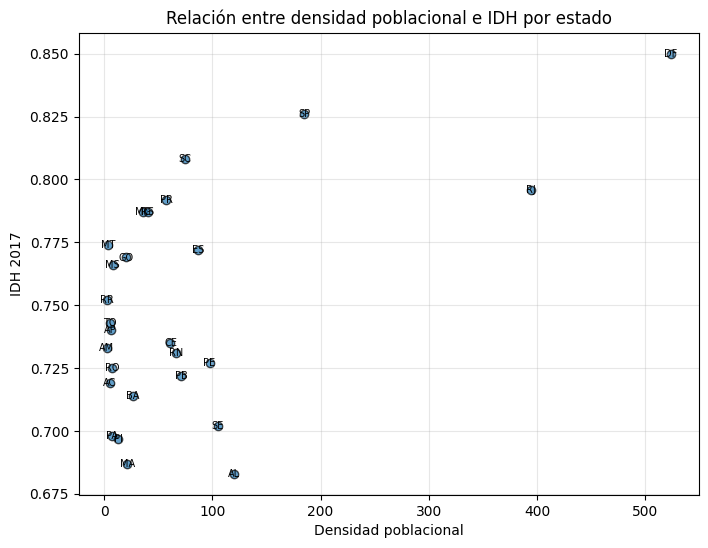

 Correlacion Pobreza vs Densidad poblacional: -0.380


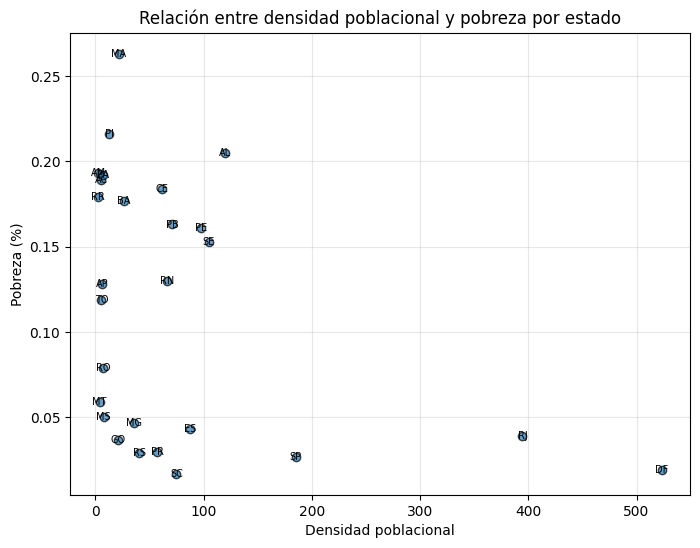

In [47]:

## esta relacionada la densidad de poblacion con el idh? 

# Promedios por estado 
idh_densidad = (
    merge.groupby("customer_state")[["HDI 2017","Demographic Density"]]
    .mean()
    .reset_index()
)

# Correlacion 
corr = idh_densidad["HDI 2017"].corr(idh_densidad["Demographic Density"])
print(f" Correlacion HDI 2017 vs Densidad poblacional: {corr:.3f}")

#  Dispersion 
plt.figure(figsize=(8,6))
plt.scatter(
    idh_densidad["Demographic Density"],
    idh_densidad["HDI 2017"],
    alpha=0.7, edgecolor="k"
)
for _, row in idh_densidad.iterrows():
    plt.text(row["Demographic Density"], row["HDI 2017"], row["customer_state"],
             fontsize=7, ha="center", va="center")

plt.xlabel("Densidad poblacional")
plt.ylabel("IDH 2017")
plt.title("Relación entre densidad poblacional e IDH por estado")
plt.grid(True, alpha=0.3)
plt.show()

#  Promedios por estado 
pov_densidad = (
    merge.groupby("customer_state")[["Poverty","Demographic Density"]]
    .mean()
    .reset_index()
)

#  Correlacion Pearson 
corr = pov_densidad["Poverty"].corr(pov_densidad["Demographic Density"])
print(f" Correlacion Pobreza vs Densidad poblacional: {corr:.3f}")

# Scatterplot 
plt.figure(figsize=(8,6))
plt.scatter(
    pov_densidad["Demographic Density"],
    pov_densidad["Poverty"],
    alpha=0.7, edgecolor="k"
)

# Etiquetas de estados
for _, row in pov_densidad.iterrows():
    plt.text(row["Demographic Density"], row["Poverty"], row["customer_state"],
             fontsize=7, ha="center", va="center")

plt.xlabel("Densidad poblacional")
plt.ylabel("Pobreza (%)")
plt.title("Relación entre densidad poblacional y pobreza por estado")
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
 ## Spearman HDI Densidad

corr_spearman = idh_densidad["HDI 2017"].corr(idh_densidad["Demographic Density"], method="spearman")
print(f"Correlación Spearman: {corr_spearman:.3f}")


🔎 Correlación Spearman: 0.248


In [ ]:
## Spearman HDI Pobreza
corr_spearman_pov = pov_densidad["Poverty"].corr(pov_densidad["Demographic Density"], method="spearman")
print(f" Correlación Spearman Pobreza vs Densidad poblacional: {corr_spearman_pov:.3f}")

🔎 Correlación Spearman Pobreza vs Densidad poblacional: -0.389


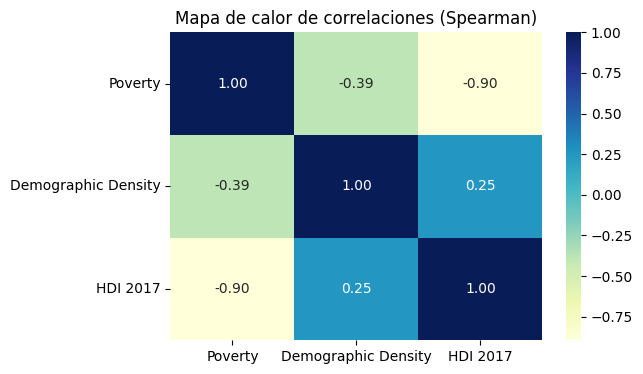

In [50]:
# Promedios por estado 
df_corr = (
    merge.groupby("customer_state")[["Poverty","Demographic Density","HDI 2017"]]
    .mean()
)

# Matriz de correlacion
corr_matrix = df_corr.corr(method="spearman")

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Mapa de calor de correlaciones (Spearman)")
plt.show()


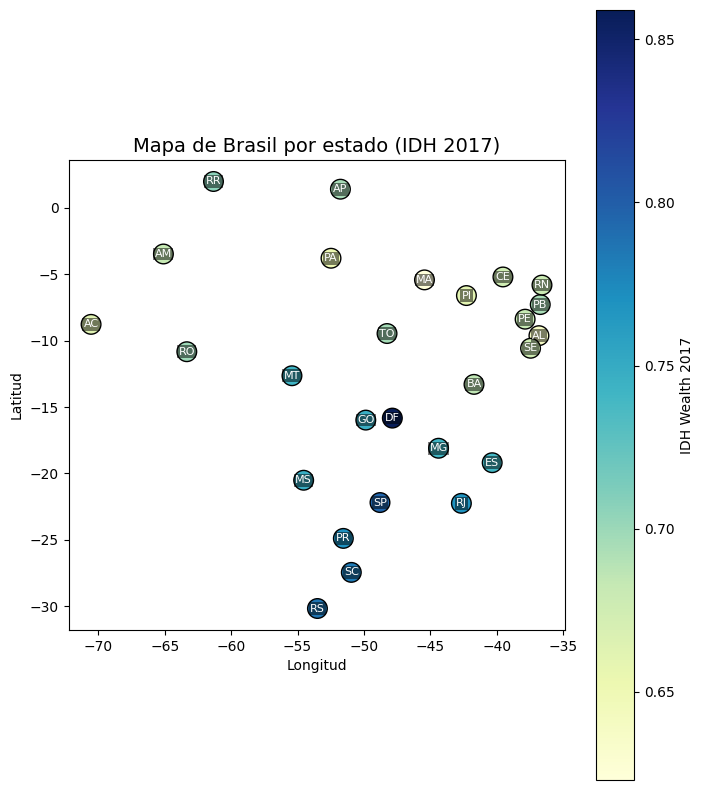

In [51]:
# Calcular centroide de cada estado con IDH
centroides = (
    merge.groupby("customer_state")[["Latitude","Longitude","HDI Wealth 2017"]]
    .mean()
    .reset_index()
    .rename(columns={"Latitude":"geolocation_lat",
                     "Longitude":"geolocation_lng",
                     "HDI Wealth 2017":"hdi_wealth_2017"})
)

# Graficar
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
plt.scatter(
    centroides["geolocation_lng"],
    centroides["geolocation_lat"],
    c=centroides["hdi_wealth_2017"],
    cmap="YlGnBu",
    s=200,
    edgecolor="k"
)

# Etiquetas con sigla del estado
for _, row in centroides.iterrows():
    plt.text(
        row["geolocation_lng"], row["geolocation_lat"], row["customer_state"],
        fontsize=8, ha="center", va="center", color="white",
        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none", pad=1)
    )

plt.colorbar(label="IDH Wealth 2017")
plt.title("Mapa de Brasil por estado (IDH 2017)", fontsize=14)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()




 Top 3 meses de mayor venta por cluster:

Cluster BAJO:
        mes  total_ventas  num_pedidos  ticket_promedio
2018-07-01      92612.89          441       210.006553
2018-01-01      90350.16          461       195.987332
2018-05-01      89363.66          396       225.665808

Cluster MEDIO:
        mes  total_ventas  num_pedidos  ticket_promedio
2018-07-01      95935.44          389       246.620668
2017-11-01      79787.56          370       215.642054
2018-03-01      77690.77          339       229.176313

Cluster ALTO:
        mes  total_ventas  num_pedidos  ticket_promedio
2018-05-01    1048862.50         6452       162.563934
2017-11-01    1042247.64         6840       152.375386
2018-04-01    1029441.96         6408       160.649494


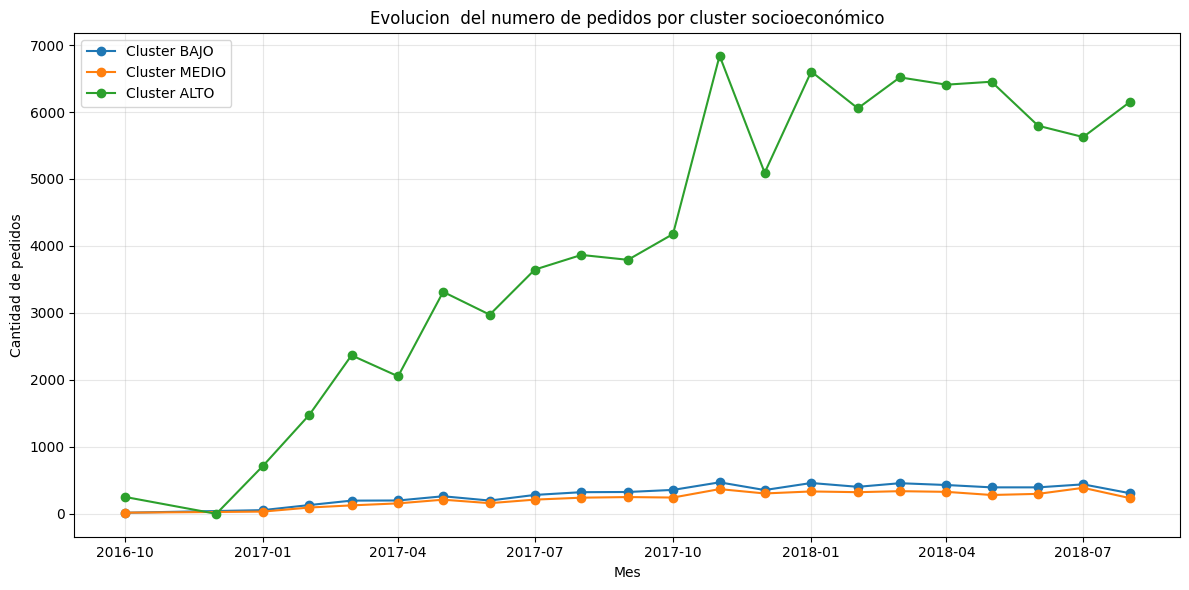


 Top 3 meses de mayor venta por cluster de Pobreza:

Cluster Pobreza BAJO:
        mes  total_ventas  num_pedidos  ticket_promedio
2018-05-01    1052301.53         6470       162.643204
2017-11-01    1049305.11         6857       153.026850
2018-04-01    1033527.68         6419       161.010699

Cluster Pobreza MEDIO:
        mes  total_ventas  num_pedidos  ticket_promedio
2018-07-01      73354.89          284       258.291866
2018-03-01      53647.55          237       226.360970
2017-11-01      51626.76          253       204.058340

Cluster Pobreza ALTO:
        mes  total_ventas  num_pedidos  ticket_promedio
2018-07-01     110133.51          530       207.799075
2018-03-01     109281.94          546       200.150073
2018-01-01     108380.63          547       198.136435


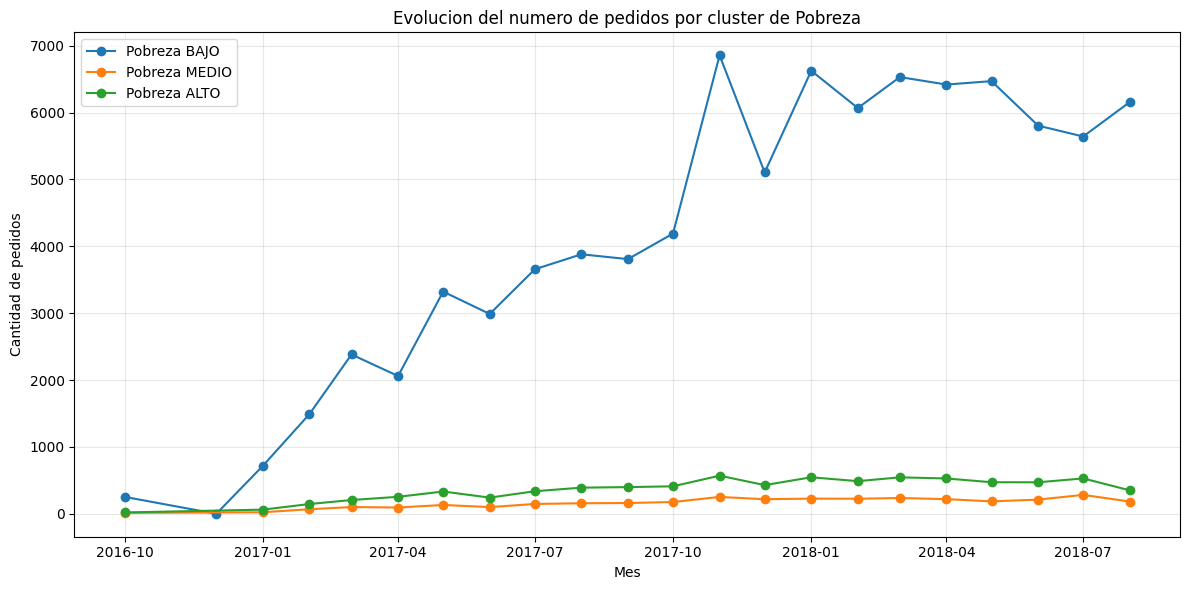

In [ ]:
# Crear columna año-mes
merge["mes"] = merge["order_purchase_timestamp"].dt.to_period("M")

# Agrupar por cluster y mes
ventas_cluster_mes = (
    merge.groupby(["cluster_idh","mes"])
    .agg(
        total_ventas=("payment_value","sum"),
        num_pedidos=("order_purchase_timestamp","count"),
        ticket_promedio=("payment_value","mean")
    )
    .reset_index()
)

# Convertir 'mes' a datetime para graficar
ventas_cluster_mes["mes"] = ventas_cluster_mes["mes"].dt.to_timestamp()



# Top 3 meses por cluster

print("\n Top 3 meses de mayor venta por cluster:")
for c in ["bajo","medio","alto"]:
    top_meses = (
        ventas_cluster_mes[ventas_cluster_mes["cluster_idh"]==c]
        .sort_values("total_ventas", ascending=False)
        .head(3)
    )
    print(f"\nCluster {c.upper()}:\n", 
          top_meses[["mes","total_ventas","num_pedidos","ticket_promedio"]].to_string(index=False))
    
   
# Grafico 

plt.figure(figsize=(12,6))
for c in ["bajo","medio","alto"]:
    df_c = ventas_cluster_mes[ventas_cluster_mes["cluster_idh"]==c]
    plt.plot(df_c["mes"], df_c["num_pedidos"], marker="o", label=f"Cluster {c.upper()}")

plt.title("Evolucion  del numero de pedidos por cluster socioeconómico")
plt.xlabel("Mes")
plt.ylabel("Cantidad de pedidos")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Agrupar por cluster de Pobreza y mes

ventas_poverty_mes = (
    merge.groupby(["cluster_poverty","mes"])
    .agg(
        total_ventas=("payment_value","sum"),
        num_pedidos=("order_purchase_timestamp","count"),
        ticket_promedio=("payment_value","mean")
    )
    .reset_index()
)

# Convertir "mes" a datetime para graficar
ventas_poverty_mes["mes"] = ventas_poverty_mes["mes"].dt.to_timestamp()


# Top 3 meses por cluster de Pobreza

print("\n Top 3 meses de mayor venta por cluster de Pobreza:")
for c in ["bajo","medio","alto"]:
    top_meses = (
        ventas_poverty_mes[ventas_poverty_mes["cluster_poverty"]==c]
        .sort_values("total_ventas", ascending=False)
        .head(3)
    )
    print(f"\nCluster Pobreza {c.upper()}:\n", 
          top_meses[["mes","total_ventas","num_pedidos","ticket_promedio"]].to_string(index=False))


# Grafico

plt.figure(figsize=(12,6))
for c in ["bajo","medio","alto"]:
    df_c = ventas_poverty_mes[ventas_poverty_mes["cluster_poverty"]==c]
    plt.plot(df_c["mes"], df_c["num_pedidos"], marker="o", label=f"Pobreza {c.upper()}")

plt.title("Evolucion del numero de pedidos por cluster de Pobreza")
plt.xlabel("Mes")
plt.ylabel("Cantidad de pedidos")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [59]:
## vamos a testear si el valor de envio y de producto se asemeja a algun tipo de distribucion 

def evaluar_distribuciones(data, nombre_variable):
    data = data.dropna()
    
    distributions = [stats.norm, stats.lognorm, stats.gamma, stats.expon]
    results = []
    
    for dist in distributions:
        try:
            # Ajustar
            params = dist.fit(data)
            
            # Log-likelihood
            ll = np.sum(dist.logpdf(data, *params))
            
            # Numero de parametros
            k = len(params)
            
            # AIC
            aic = 2*k - 2*ll
            
            results.append((dist.name, aic, params))
        except Exception as e:
            print(f" Error con {dist.name}: {e}")
    
    # Ordenar por mejor AIC
    results = sorted(results, key=lambda x: x[1])
    
    print(f"\n Comparacion de distribuciones para {nombre_variable}:")
    for name, aic, params in results:
        print(f"{name:10s} | AIC={aic:.2f} | params={params}")
    
    return results[0]  

# Evaluar Precio 
best_price = evaluar_distribuciones(merge["price"], "Precio del producto")

# Evaluar Valor de Envio 
best_freight = evaluar_distribuciones(merge["freight_value"], "Valor del envío")



 Comparacion de distribuciones para Precio del producto:
lognorm    | AIC=1155356.68 | params=(np.float64(0.9319494803267102), 0.7179427116967528, np.float64(76.39950925755566))
gamma      | AIC=1181366.30 | params=(np.float64(1.251612676973707), np.float64(0.37975845832512833), np.float64(98.500860830877))
expon      | AIC=1182168.40 | params=(0.85, 123.51520310162955)
norm       | AIC=1353421.94 | params=(np.float64(124.36520310162955), np.float64(188.67195921818268))

 Comparacion de distribuciones para Valor del envío:
lognorm    | AIC=744368.07 | params=(np.float64(0.47506618866285827), -2.451425875807703, np.float64(19.839932014487875))
expon      | AIC=813851.08 | params=(0.0, 20.170216287491144)
norm       | AIC=850045.39 | params=(np.float64(20.170216287491144), np.float64(15.85283100485077))
gamma      | AIC=2293767.15 | params=(np.float64(0.039843541647627365), np.float64(-6.990542846611835e-25), np.float64(3.6750427767861744))


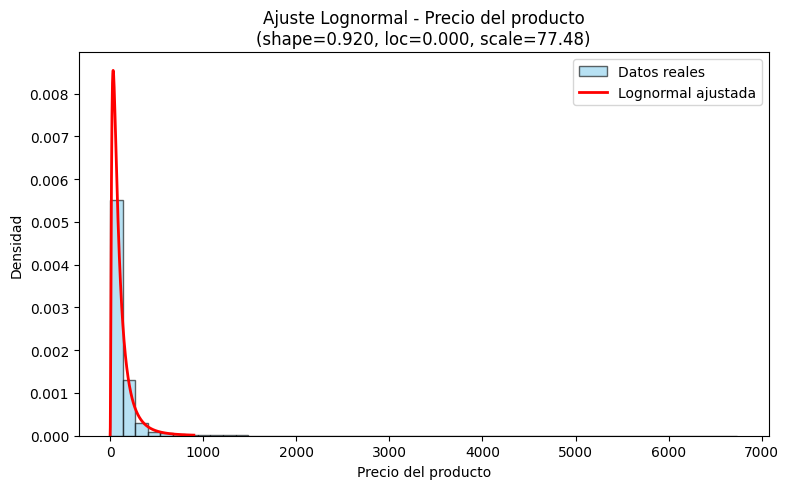

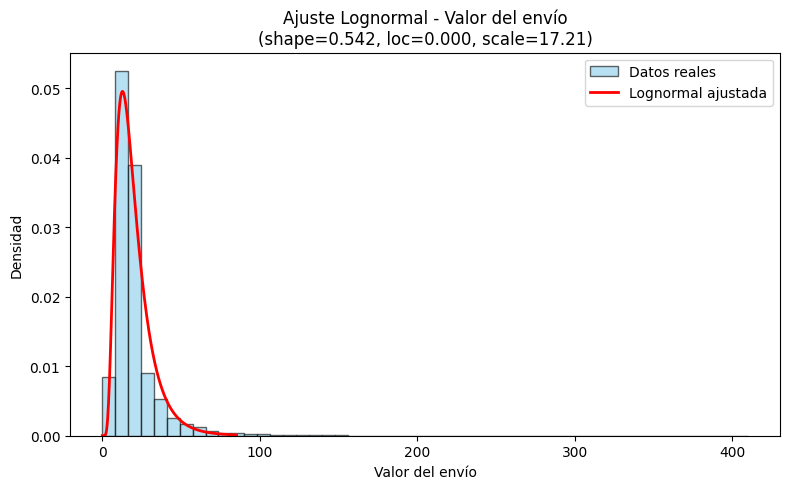

In [ ]:
## como se asemejan ambos a logaritmica graficamos

def plot_lognormal_fit(data, nombre_variable):
    data = data[data > 0].dropna()  # eliminar ceros/NaN
    shape, loc, scale = lognorm.fit(data, floc=0)  # forzar loc=0 porque son >0
    
    # Histograma
    plt.figure(figsize=(8,5))
    plt.hist(data, bins=50, density=True, alpha=0.6, color="skyblue", edgecolor="black", label="Datos reales")
    
    # Curva lognormal ajustada
    x = np.linspace(data.min(), data.quantile(0.99), 500)  # hasta percentil 99 para evitar colas largas
    pdf = lognorm.pdf(x, shape, loc, scale)
    plt.plot(x, pdf, "r-", lw=2, label="Lognormal ajustada")
    
    # Etiquetas
    plt.title(f"Ajuste Lognormal - {nombre_variable}\n(shape={shape:.3f}, loc={loc:.3f}, scale={scale:.2f})")
    plt.xlabel(nombre_variable)
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()

#  Grafico para Precio del producto 
plot_lognormal_fit(merge["price"], "Precio del producto")
plot_lognormal_fit(merge["freight_value"], "Valor del envío")


In [67]:
## vamos a calcular la prob superar la media de envio y el valor de envio en un 95% de los casos

data = merge["freight_value"]
data = data[data > 0].dropna()
shape, loc, scale = lognorm.fit(data, floc=0)

# Calcular media teórica
mean = np.exp(np.log(scale) + (shape**2) / 2)

# Probabilidad de superar la media
p_supera_media = 1 - lognorm.cdf(mean, shape, loc=loc, scale=scale)

print(f"Media valor del envío: {mean:.2f}")
print(f"Probabilidad de superar la media: {p_supera_media:.3f}")

# Cuantiles 2.5% y 97.5%
q_low, q_high = lognorm.ppf([0.025, 0.975], shape, loc=loc, scale=scale)

print(f"Rango del 95% del valor del envío: [{q_low:.2f}, {q_high:.2f}]")

Media valor del envío: 19.93
Probabilidad de superar la media: 0.393
Rango del 95% del valor del envío: [5.95, 49.79]
